### E16 DCGAN New Image

- 목표
    - 생성 모델링 개념을 이해하며 판별 모델링과의 차이 알기 
    - Pix2Pix, CycleGAN 등의 이미지 관련 다양한 생성 모델링의 응용을 접하며 흥미 가지기
    - Fashion MNIST 데이터셋의 의미를 알기
    - 생성적 적대 신경망(GAN)의 구조와 원리를 이해하기
    - 텐서플로우로 짠 DCGAN 학습 코드를 익히며 응용하기

In [204]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt

import warnings

warnings.filterwarnings(action='ignore')

%matplotlib inline

#### 1. 데이터셋 구성하기 

In [205]:
cifar10 = tf.keras.datasets.cifar10

(train_x, _), (test_x, _) = cifar10.load_data()

train_x.shape

(50000, 32, 32, 3)

In [206]:
print("max pixel : ", train_x.max())
print("min pixel : ", train_x.min())

max pixel :  255
min pixel :  0


In [207]:
# 정규화
train_x = (train_x - 127.5) / 127.5

print("max pixel : ", train_x.max())
print("min pixel : ", train_x.min())

max pixel :  1.0
min pixel :  -1.0


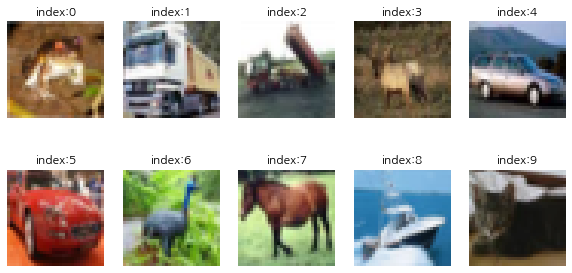

In [208]:
plt.figure(figsize=(10, 5))

for i in range(10):
    plt.subplot(2, 5, i+1)
    # 컬러이미지는 [0, 255]인데 반해 정규화된 값의 범위는 [-1, 1]로 음수가 존재하여 [0, 1]로 변경하여 시각화
    plt.imshow((train_x[i].reshape(32, 32, 3) + 1) /2)
    plt.title(f'index:{i}')
    plt.axis('off')
plt.show()

In [209]:
BUFFER_SIZE = 50000
BATCH_SIZE = 128

train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

#### 2. 생성자 모델 구현하기 

In [210]:
def make_generator_model():
    
    model = tf.keras.Sequential()
    
    model.add(layers.Dense(4*4*256,  input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Reshape((4, 4, 256)))
    
    model.add(layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Conv2DTranspose(128, kernel_size=(4, 4), strides=(2, 2), padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Conv2D(3, kernel_size=(3, 3), padding='same', activation='tanh'))
    
    return model

In [211]:
generator = make_generator_model()

generator.summary()

Model: "sequential_20"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_20 (Dense)             (None, 4096)              413696    
_________________________________________________________________
batch_normalization_38 (Batc (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu_74 (LeakyReLU)   (None, 4096)              0         
_________________________________________________________________
reshape_10 (Reshape)         (None, 4, 4, 256)         0         
_________________________________________________________________
conv2d_transpose_30 (Conv2DT (None, 8, 8, 128)         524416    
_________________________________________________________________
batch_normalization_39 (Batc (None, 8, 8, 128)         512       
_________________________________________________________________
leaky_re_lu_75 (LeakyReLU)   (None, 8, 8, 128)       

In [212]:
noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
generated_image.shape

TensorShape([1, 32, 32, 3])

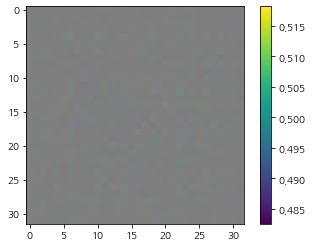

In [213]:
plt.imshow((generated_image[0, :, :, :]+1)/2)
plt.colorbar()
plt.show()

#### 3. 판별자 모델 구현하기

In [214]:
def make_discriminator_model():
    
    model = tf.keras.Sequential()
    
    model.add(layers.Conv2D(64, (3, 3), padding='same', input_shape=[32, 32, 3]))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    
    model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))

    model.add(layers.Flatten())
    model.add(layers.Dropout(0.4))
    
    model.add(layers.Dense(1))
    
    return model


In [215]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_44 (Conv2D)           (None, 32, 32, 64)        1792      
_________________________________________________________________
leaky_re_lu_78 (LeakyReLU)   (None, 32, 32, 64)        0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
leaky_re_lu_79 (LeakyReLU)   (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 8, 8, 128)         147584    
_________________________________________________________________
leaky_re_lu_80 (LeakyReLU)   (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 4, 4, 256)       

In [216]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[-0.00040751]], dtype=float32)>

#### 4. 손실함수와 최적화함수 구현하기

In [217]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [218]:
#generator loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# discriminator loss

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [219]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [220]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [221]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

#### 5. 훈련과정 상세 기능 구현하기

In [222]:
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)
        
        real_accuracy, fake_accuracy = discriminator_accuracy(real_output, fake_output)
        
    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))
    
    return gen_loss, disc_loss, real_accuracy, fake_accuracy

In [223]:
def generate_and_save_images(model, epoch, it, sample_seeds):
    
    predictions = model(sample_seeds, training=False)
    
    fig = plt.figure(figsize=(6, 6))
    for i in range(predictions.shape[0]):
        plt.subplot(4, 4, i+1)
        plt.imshow((predictions[i, :, :, :]+1)/2)
        plt.axis('off')
    try:
        plt.savefig(os.getenv('HOME') + f'/Aiffel/16_DCGAN_newimage/generated_samples/sample_epoch_{epoch}_iter_{it}.png')
    except:
        os.mkdir('./generated_samples')
        
    plt.show()

In [224]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

def draw_train_history(history, epoch):
    
    plt.subplot(211)
    plt.plot(history['gen_loss'])
    plt.plot(history['disc_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('batch iters')
    plt.legend(['gen_loss', 'disc_loss'], loc='upper left')
    
    plt.subplot(212)
    plt.plot(history['fake_accuracy'])
    plt.plot(history['real_accuracy'])
    plt.title('discriminator accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('batch iters')
    plt.legend(['fake_accuracy', 'real_accuracy'], loc='upper left')
    
    try:
        plt.savefig(os.getenv('HOME') + f'/Aiffel/16_DCGAN_newimage/training_history/train_history_{epoch}.png')
    except:
        os.mkdir('./training_history')
        
    plt.show()

In [225]:
checkpoint_dir = os.getenv('HOME') + '/Aiffel/16_DCGAN_newimage/training_checkpoints'

checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                discriminator_optimizer=discriminator_optimizer,
                                generator=generator,
                                discriminator=discriminator)

In [226]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}
    
    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)
            
            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print(f'Epoch {epoch+1} iter{it+1}')
                print(f'Time for epoch {epoch+1} : {int(time.time()-epoch_start)}')
                
        if(epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)
            
        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print(f'Time for traing : {int(time.time()-start)}')
        
        draw_train_history(history, epoch)

In [227]:
save_every = 5
EPOCHS = 400

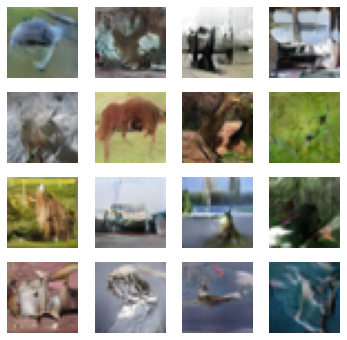

Time for traing : 11503


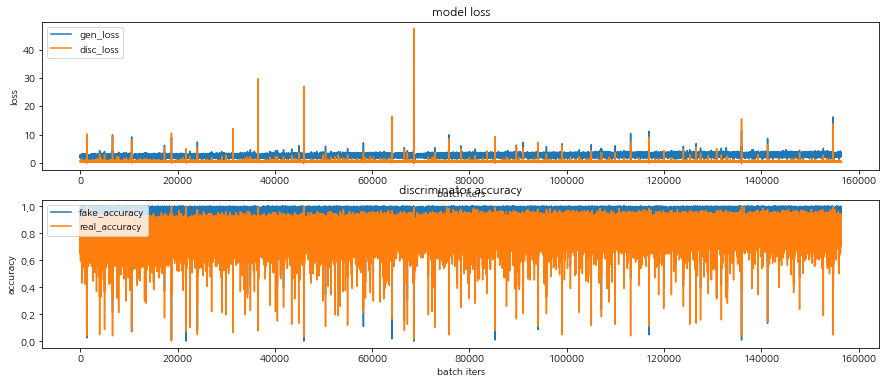

CPU times: user 3h 13min 40s, sys: 2min 38s, total: 3h 16min 19s
Wall time: 3h 11min 47s


In [231]:
%%time
train(train_dataset, EPOCHS, save_every)

In [232]:
anim_file = os.getenv('HOME') + '/Aiffel/16_DCGAN_newimage/cifar100_dcgan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
    filenames =  glob.glob('{}/Aiffel/16_DCGAN_newimage/generated_samples/sample*.png'.format(os.getenv('HOME')))
    filenames = sorted(filenames)
    last = -1
    for i, filename in enumerate(filenames):
        frame = 2*(i**0.5)
        if round(frame) > round(last):
            last = frame
        else:
            continue
        image = imageio.imread(filename)
        writer.append_data(image)
    image = imageio.imread(filename)
    writer.append_data(image)

!ls -l ~/Aiffel/16_DCGAN_newimage/cifar100_dcgan.gif

-rw-rw-r-- 1 aiffel aiffel 9607291 10월 13 02:41 /home/aiffel/Aiffel/16_DCGAN_newimage/cifar100_dcgan.gif


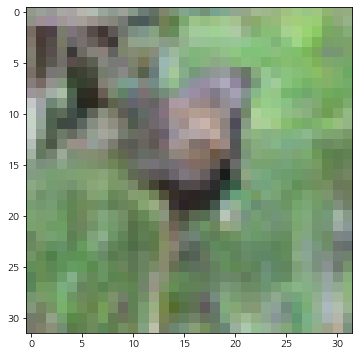

In [233]:
checkpoint_dir = os.getenv('HOME')+'/Aiffel/16_DCGAN_newimage/training_checkpoints'

latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator = checkpoint.generator
discriminator = checkpoint.discriminator


noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)

np_generated = generated_image.numpy()
np_generated = (np_generated * 127.5) + 127.5   # reverse of normalization
np_generated = np_generated.astype(int)
plt.imshow(np_generated[0])
plt.show() 

#### 6. 결과

##### 6-1 TEST 1
- 학습 노드 기본값 사용
- epochs 100
- batch size 256
![history](./training_history/test1/train_history_99.png)
![Sample](./generated_samples/test1/sample_epoch_100_iter_195.png)
![result_gif](./result_gif/test1/cifar100_dcgan_epochs100.gif)

**epochs를 400으로 설정하여 학습을 더 많이 진행하여도 결과의 변화가 없음**

##### 6-2 TEST 2
- dropout : 0.3 -> 0.4
- generator learning rate : 1e-4 -> 2e-4
- discriminator learning rate : 1e-4 -> 2e-4
- epochs 100
- batch size 256
    
![history](./training_history/test2/train_history_99.png)
![Sample](./generated_samples/test2/sample_epoch_100_iter_195.png)
![result_gif](./result_gif/test2/cifar100_dcgan.gif)

**- learning rate를 변경 시켜보았지만 큰 변화가 없음**   
**- 어떤 물체가 생성되는 것처럼 보이지만 뚜렷하지 않아 더 많은 학습이 필요할 것으로 보임**

##### 6-3 TEST 3
- [How to Develop a GAN to Generate CIFAR10 Small Color Photographs](https://machinelearningmastery.com/how-to-develop-a-generative-adversarial-network-for-a-cifar-10-small-object-photographs-from-scratch/) 하이퍼 파라미터 사용
- generator 
    - LeakyReLU(alpha=0.2)
    - kernel size (4, 4)
    - reshape(4, 4, 256)
    - Adam(lr = 2e-4, beta_1=0.5)
- discriminator
    - LeakyReLU(alpha=0.2)
    - kernel size (3, 3)
    - Adam(lr = 2e-4, beta_1=0.5)
- epochs 400
- batch size 128
![history](./training_history/test3/train_history_399.png)
![Sample](./generated_samples/test3/sample_epoch_400_iter_390.png)
![result_gif](./result_gif/test3/cifar100_dcgan.gif)

**- 이전의 학습보다는 배경과 사물의 구분이 확실해지고 대략적으로 사물을 구분이 가능한 이미지도 생성이 되지만 아직은 형체를 알아보기 힘듬**   
**- 학습이 진행될수록 fake loss가 높아지고 real accuracy가 오히려 높아지는 것을 볼 수 있어 200epochs가 적당할 것으로 예상됨**

#### 7. 고찰

- GAN은 학습에 많은 자원과 시간이 필요하여 다양한 테스트를 수행하는데 어려움이 있었다
- 이미지의 각 픽셀값을 일률적으로 0~1사이로 정규화를 하는 것이 아니라 activation function, 데이터 등 여러가지 요소의 관계에 따라 알맞게 해주어야 한다는 것을 알 수 있었다. 
- GAN 네트워크를 실제 구현해보면서 네트워크가 학습을 하는 방식을 이해할 수 있었다. 